In [706]:
import pandas as pd
import numpy as np
import sqlite3
import datetime
import sklearn
import sqlalchemy as sa
from sklearn.model_selection import TimeSeriesSplit
from kmeans_smote import KMeansSMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE 

In [667]:
from collections import Counter
from sklearn.base import BaseEstimator
from tqdm import trange
from imblearn.combine import SMOTETomek
from sklearn.linear_model import LogisticRegression

In [668]:
data = pd.read_csv("../data/coms_sep/train_cntrs.csv", index_col=0)

In [707]:
class forget_model(BaseEstimator):
    def __init__(self, model=LogisticRegression(),n_splits=4, balance=None):
        self.models = [] # лист, в котором будут храниться обученные модели для каждого сплита
        self.n_splits = n_splits # число сплитов
        self.balance = balance # должен поддерживать большинство 
        # методов из imbalanced-learn, которые поддерживают fit_sample
        self.model = model # модели, поддерживающие fit, predict и predict_proba
    
    # inputs - уникальные значения дат
    def _iterate_megabatches(self, inputs, n_splits): # делает разбиение по времени без пересечений
        batchsize = len(inputs)//n_splits
        for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
            excerpt = np.arange(start_idx, start_idx + batchsize-1)
            yield inputs[excerpt]

    
    # X - это весь датафрейм за два месяца ВМЕСТЕ с таргетом
    def fit(self, X):
        models = [] # пустой список моделей
        batch_df_i_neg = pd.DataFrame() # заготовки для не фрода в итом сплите
        batch_df_pos = pd.DataFrame() #  заготовка для фрода
        unique_TS_split = np.array(sorted(X.TS_indexer.unique())) # получаем число уникальных дат
        
        for train_index in self._iterate_megabatches(inputs=unique_TS_split, n_splits=self.n_splits): 
            batch_df_i_old_neg = batch_df_i_neg # сохраняем прошлуб базу не фрода
            batch_df_i = X[X.TS_indexer.isin(train_index)] # получаем базу данных итого сплита
            batch_df_i_pos = batch_df_i[batch_df_i.label==1] #  разбиваем ее на фрод
            batch_df_i_neg = batch_df_i[batch_df_i.label==0] #  и не фрод
            batch_df_pos = pd.concat([batch_df_pos, batch_df_i_pos]) # получаем данные не фрода для обучения
            batch_df_neg = pd.concat([batch_df_i_old_neg, batch_df_i_neg]) # получаем данные фрода для обучения
            df_i = pd.concat([batch_df_pos, batch_df_neg]) #  объединяем фрод и не фрод
            X_df_i = df_i.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1) #  выделяем обучение
            y_df_i = df_i.label #  и таргет
            if self.balance is None: #  без балансировки просто продолжаем
                pass
            else: 
                balancing = self.balance 
                X_df_balanced_i, y_df_balanced_i = balancing.fit_sample(X_df_i, y_df_i) # делаем перебалансировку
                X_df_i = X_df_balanced_i
                y_df_i = y_df_balanced_i

            model_i = self.model # итая модель
            model_i.fit(X_df_i, y_df_i) # обучаем итую модель

            
            models.append(model_i) #  сохраняем ее в лист
        self.models = models #  возвращаем в селф


    def predict(self, X_test): 
        pr = np.zeros(len(X_test)) # заготовка
        for model_i in self.models:
            pr_i = model_i.predict(X_test) # предсказания итой модели
            pr = np.vstack([pr,pr_i]) # объединяем предсказания
        predictions = np.array([Counter(x).most_common(1)[0][0] for x in pr[1:].T]) #  простое голосвание
        return predictions
    
    def predict_proba(self, X_test):
        pr = np.array([np.zeros(len(X_test))]*2).T #заготовка
        for model_i in self.models:
            pr_i = model_i.predict_proba(X_test) #  получаем вероятности итой модели
            pr = np.sum([pr, pr_i], axis = 0) 
        predictions = pr/len(self.models) #  получаем усредненные вероятности
        return predictions


In [670]:
data['TS_indexer'] = data.short_date
data.fillna(0, inplace=True)
data.drop(['event_id', 'event_time'], axis = 1, inplace=True)

In [708]:
m = forget_model(model=LogisticRegression(class_weight='balanced'), n_splits=2, balance=SMOTE(random_state = 42))

In [709]:
def train_val_ts_split(X, th=0.7, split_target=None): # X - датафрейм, в котором есть  TS_indexer
    unique_TS_split = np.array(sorted(X.TS_indexer.unique()))
    batchsize = int(len(unique_TS_split)*th)
    excerpt_train = np.arange(0, batchsize)
    excerpt_val =  np.arange(batchsize, len(unique_TS_split))
    d_train =  X[X.TS_indexer.isin(unique_TS_split[excerpt_train])]
    d_val = X[X.TS_indexer.isin(unique_TS_split[excerpt_val])]
    if split_target is None:
        return d_train, d_val
    else:
        return d_train.drop('label', axis=1), d_train.label, d_val.drop('label', axis=1), d_val.label

In [710]:
X1, X2 = train_val_ts_split(data , th=0.7, split_target=None)

In [711]:
m.fit(X1)

100%|██████████| 2/2 [00:01<00:00,  1.22it/s]


In [712]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [713]:
y2 = X2['label'].values

In [714]:
preds_proba = m.predict_proba(X2.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1))
preds = m.predict(X2.drop(['label', 'short_date','TS_indexer', 'user_id'], axis=1))

In [715]:
average_precision = average_precision_score(y2, preds)

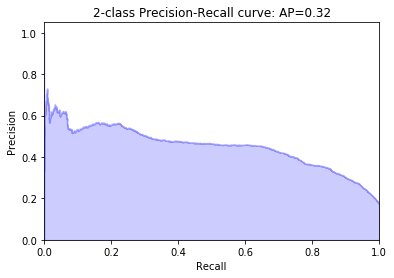

In [716]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y2, preds_proba[:, 1])

plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [717]:
from sklearn.metrics import f1_score

In [718]:
from sklearn import metrics
metrics.auc(recall, precision)

0.4515534254864552

In [719]:
def f1sc(pr, rec):
    return 2 * (pr * rec)/(pr + rec)

In [720]:
f1sc_log = []
for pr, rec in zip(precision, recall):
    f1sc_log.append(f1sc(pr, rec))

/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


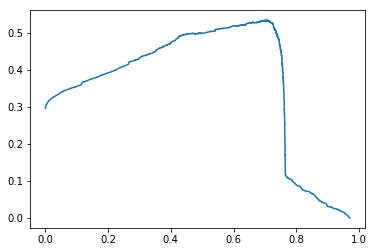

In [721]:
plt.plot(thresholds[:-1], f1sc_log[:-2])

In [722]:
# лучший трешхолд с точки зрения F1 меры
optim_thresh = thresholds[:-1][np.argmax(f1sc_log[:-2])]
optim_thresh

0.9711964935871417

In [723]:
preds

array([0., 0., 0., ..., 0., 0., 1.])

Ищем число срабатываний

$$ recall = \frac{TP}{l_+} $$

$$ precision = \frac{TP}{TP + FP} $$

Число срабатываний: $ TP + FP $

Еще пару формул:
$$ TP = recall \cdot l_+ $$
$$ FP = (\frac{TP}{precision} - TP) $$

In [687]:
pr = precision[:-2][np.argmax(f1sc_log[:-2])]
rec = recall[:-2][np.argmax(f1sc_log[:-2])]

In [688]:
TP = rec * np.sum(y2)
FP = (TP/pr) - TP
print("Число срабатываиний: {}".format(TP+FP))

Число срабатываиний: nan


/home/alex/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [665]:
np.sum(preds_proba[:, 1] >= optim_thresh)

4952